# Workflow System Comprehensive Test Notebook

This notebook thoroughly tests the workflow system including:
- Workflow creation and compilation
- Workflow execution and state management
- Individual workflow step testing
- Error handling and recovery
- Workflow persistence and resumption
- Human approval system
- Integration with external services (GitHub, Jira, Confluence)

In [1]:
# Setup and imports
import os
import asyncio
import json
import time
import uuid
from typing import Dict, Any, List
from IPython.display import display, HTML, Image

# Change to backend directory
os.chdir("../../../backend/")
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\zakir.hussain\Documents\zakir\projects\hackathon\ProjectEnigma\backend


In [2]:
# Import workflow components
from app.workflows.release_workflow import create_release_workflow, WorkflowState
from app.workflows.workflow_manager import get_workflow_manager, WorkflowManager
from app.integrations.factory import get_api_factory
from app.core.config import get_settings
from app.models.api import ChatRequest

print("Workflow components imported successfully")
settings = get_settings()
settings.github_organization

Workflow components imported successfully


'ProjectEnigmaHackathon'

## 1. Workflow Creation and Visualization Test

‚úÖ Workflow created successfully: CompiledStateGraph
‚úÖ Workflow graph retrieved: Graph


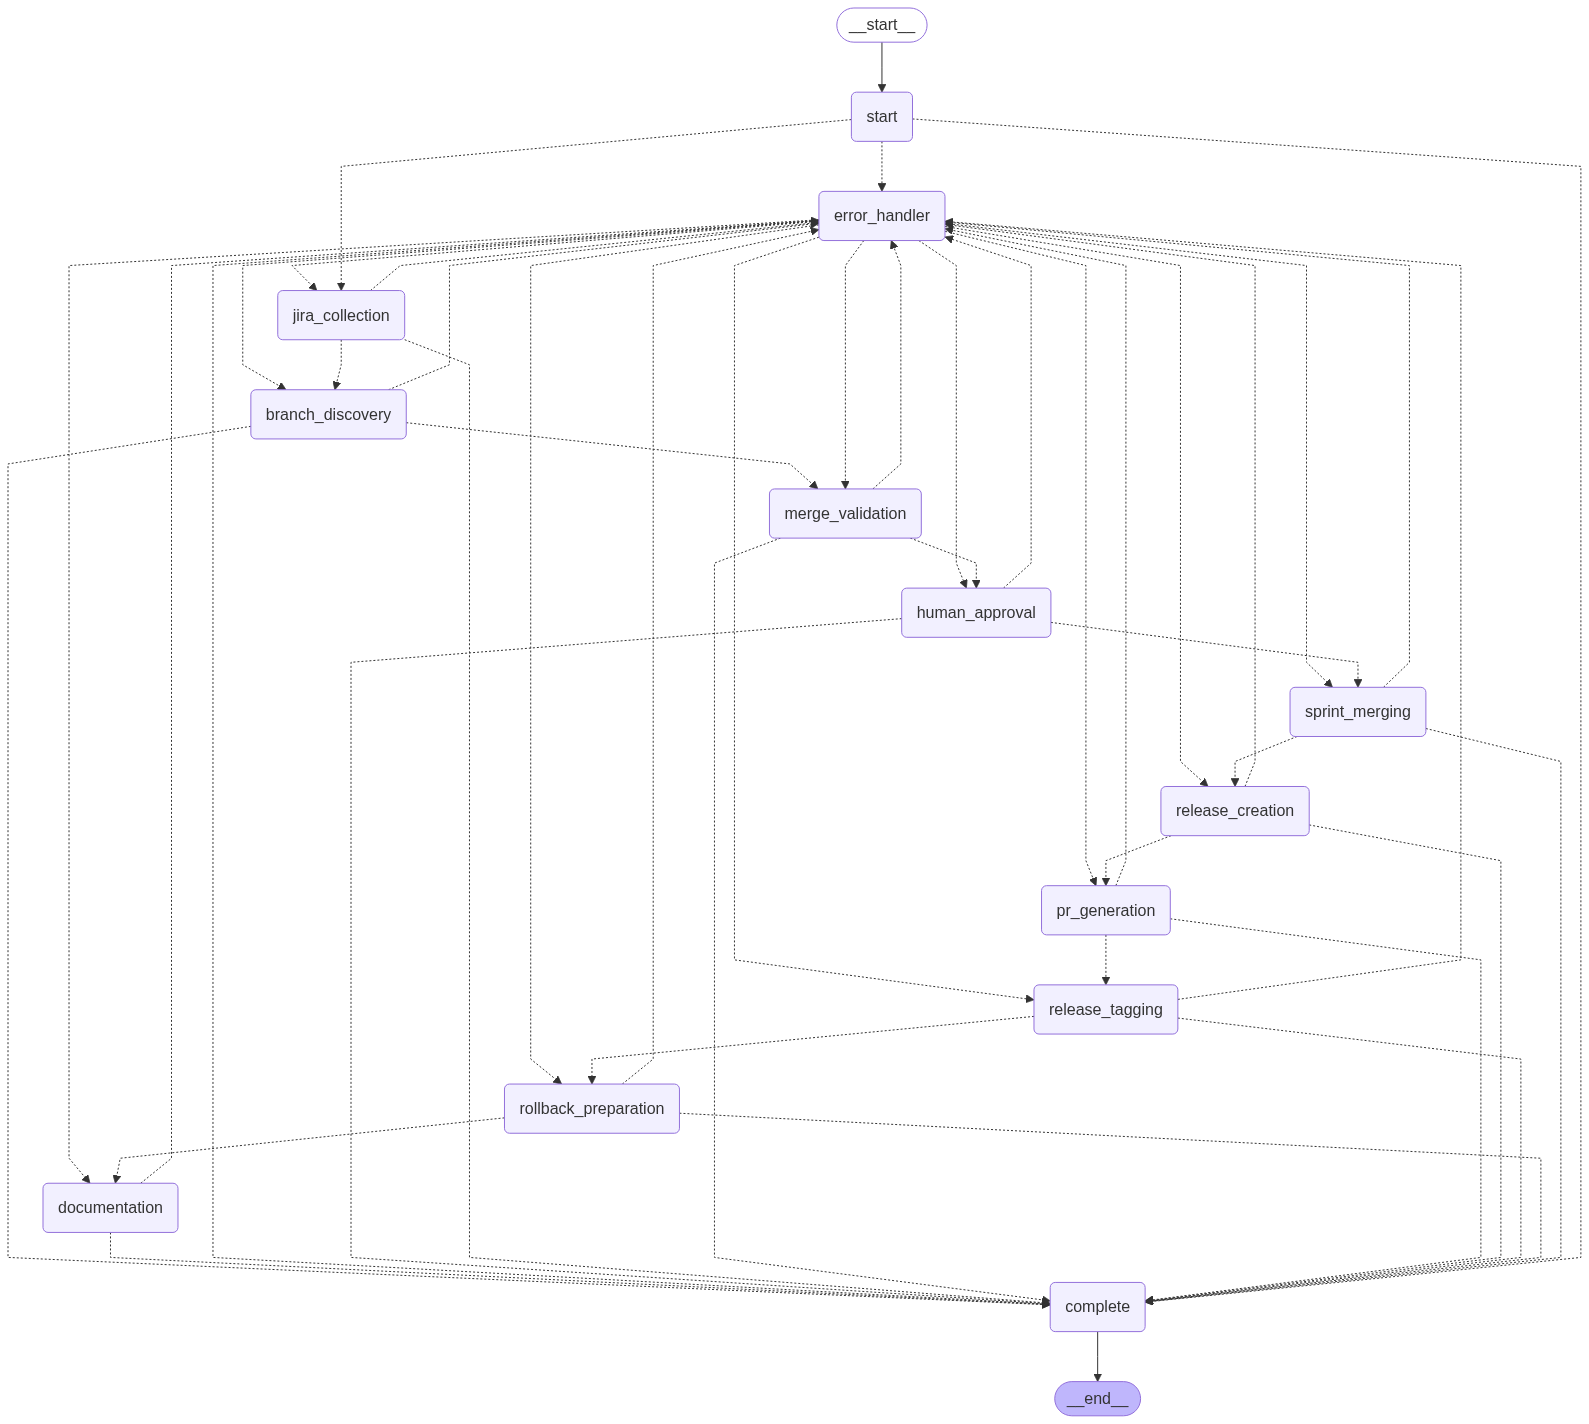

‚úÖ Workflow visualization generated successfully

Workflow nodes (15):
  1. __start__
  2. start
  3. jira_collection
  4. branch_discovery
  5. merge_validation
  6. human_approval
  7. sprint_merging
  8. release_creation
  9. pr_generation
  10. release_tagging
  11. rollback_preparation
  12. documentation
  13. error_handler
  14. complete
  15. __end__


In [24]:
# Test workflow creation and visualization
def test_workflow_creation():
    try:
        # Create the workflow
        workflow = create_release_workflow()
        print(f"‚úÖ Workflow created successfully: {type(workflow).__name__}")
        
        # Get workflow graph
        graph = workflow.get_graph()
        print(f"‚úÖ Workflow graph retrieved: {type(graph).__name__}")
        
        # Display workflow visualization
        try:
            mermaid_png = graph.draw_mermaid_png()
            display(Image(mermaid_png))
            print("‚úÖ Workflow visualization generated successfully")
        except Exception as e:
            print(f"‚ö†Ô∏è  Visualization error (non-critical): {e}")
        
        # Get workflow nodes
        nodes = list(graph.nodes.keys())
        print(f"\nWorkflow nodes ({len(nodes)}):")
        for i, node in enumerate(nodes, 1):
            print(f"  {i}. {node}")
        
        return workflow, graph, nodes
        
    except Exception as e:
        print(f"‚ùå Workflow creation failed: {e}")
        return None, None, None

# Run workflow creation test
workflow, graph, nodes = test_workflow_creation()

## 2. Workflow Manager Initialization Test

In [4]:
# Test workflow manager initialization
def test_workflow_manager():
    try:
        # Compile the workflow
        # compiled_workflow = workflow.compile()
        # print(f"‚úÖ Workflow compiled successfully: {type(compiled_workflow).__name__}")
        
        # Get workflow manager
        manager = get_workflow_manager()
        print(f"‚úÖ Workflow manager retrieved: {type(manager).__name__}")
        
        # Create new workflow manager instance
        new_manager = WorkflowManager(workflow, enable_persistence=True)
        print(f"‚úÖ New workflow manager created: {type(new_manager).__name__}")

        # Create new workflow manager instance
        new_manager = WorkflowManager(workflow, enable_persistence=False)
        print(f"‚úÖ New workflow manager created: {type(new_manager).__name__}")
        
        return workflow, manager, new_manager
        
    except Exception as e:
        print(f"‚ùå Workflow manager initialization failed: {e}")
        return None, None, None

# Run workflow manager test
compiled_workflow, manager, new_manager = test_workflow_manager()

‚úÖ Workflow manager retrieved: WorkflowManager
‚úÖ New workflow manager created: WorkflowManager
‚úÖ New workflow manager created: WorkflowManager


## 3. Workflow State Structure Test

In [5]:
# Test workflow state structure
def test_workflow_state_structure():
    try:
        # Create sample workflow state
        sample_state: WorkflowState = {
            # Core workflow data
            "messages": [],
            "repositories": ["test-owner/test-repo-1", "test-owner/test-repo-2"],
            "fix_version": "v1.0.0",
            "sprint_name": "Sprint 2024.1",
            "release_type": "release",
            
            # Execution tracking
            "current_step": "start_workflow",
            "workflow_complete": False,
            "workflow_id": str(uuid.uuid4()),
            "workflow_paused": False,
            
            # Step results
            "jira_tickets": [],
            "feature_branches": {},
            "merge_status": {},
            "pull_requests": [],
            "release_branches": [],
            "rollback_branches": [],
            "confluence_url": "",
            
            # Error handling and recovery
            "error": "",
            "error_step": "",
            "retry_count": 0,
            "can_continue": True,
            
            # Progress tracking
            "steps_completed": [],
            "steps_failed": [],
            
            # Human approval system
            "approval_required": False,
            "approval_message": "",
            "approval_id": "",
            "approval_decision": {}
        }
        
        print(f"‚úÖ Sample workflow state created with {len(sample_state)} fields")
        print("\nState structure:")
        for key, value in sample_state.items():
            print(f"  {key}: {type(value).__name__} = {value}")
        
        return sample_state
        
    except Exception as e:
        print(f"‚ùå Workflow state structure test failed: {e}")
        return None

# Run workflow state structure test
sample_state = test_workflow_state_structure()

‚úÖ Sample workflow state created with 26 fields

State structure:
  messages: list = []
  repositories: list = ['test-owner/test-repo-1', 'test-owner/test-repo-2']
  fix_version: str = v1.0.0
  sprint_name: str = Sprint 2024.1
  release_type: str = release
  current_step: str = start_workflow
  workflow_complete: bool = False
  workflow_id: str = d4be06c7-d82a-4966-b34e-233e337796df
  workflow_paused: bool = False
  jira_tickets: list = []
  feature_branches: dict = {}
  merge_status: dict = {}
  pull_requests: list = []
  release_branches: list = []
  rollback_branches: list = []
  confluence_url: str = 
  error: str = 
  error_step: str = 
  retry_count: int = 0
  can_continue: bool = True
  steps_completed: list = []
  steps_failed: list = []
  approval_required: bool = False
  approval_message: str = 
  approval_id: str = 
  approval_decision: dict = {}


## 4. Individual Workflow Step Testing

In [20]:
import asyncio
from app.workflows import release_workflow_with_refracting as rw
from app.workflows.release_workflow_with_refracting import WorkflowState

# Map step names to their refactored top-level async functions
STEP_FUNCTIONS = {
    "start": rw.start_workflow,
    "jira_collection": rw.collect_jira_tickets,
    "branch_discovery": rw.discover_feature_branches,
    "merge_validation": rw.validate_merge_status,
    "human_approval": rw.request_human_approval,
    "sprint_merging": rw.merge_sprint_branches,
    "release_creation": rw.create_release_branches,
    "pr_generation": rw.generate_pull_requests,
    "release_tagging": rw.create_release_tags,
    "rollback_preparation": rw.prepare_rollback_branches,
    "documentation": rw.generate_confluence_docs,
    "error_handler": rw.handle_workflow_error_node,
    "complete": rw.complete_workflow,
}

# Sample test state with enough data to satisfy all steps
def get_sample_state() -> WorkflowState:
    return WorkflowState(
        messages=[],
        repositories=["demo-repo"],
        fix_version="v2.1.0",
        sprint_name="sprint-2024-01",
        workflow_id="test-workflow-id",
        steps_completed=[],
        steps_failed=[],
        approval_decision={"approved": True, "user_id": "test-user"},
        feature_branches={"demo-repo": ["feature/PROJ-123"]},
        merge_status={"demo-repo": {"feature/PROJ-123": True}},
        jira_tickets=[
            {
                "id": "PROJ-123",
                "summary": "Sample ticket",
                "status": "Done",
                "assignee": "user1",
                "priority": "High",
            }
        ],
    )

# Run each step function independently and print results
async def test_individual_workflow_steps():
    results = {}
    for step_name, step_func in STEP_FUNCTIONS.items():
        print(f"\nüîπ Testing step: {step_name}")
        try:
            state = get_sample_state()
            state["current_step"] = step_name
            result_state = await step_func(state)
            print(f"‚úÖ {step_name}: SUCCESS")
            results[step_name] = "SUCCESS"
        except Exception as e:
            print(f"‚ùå {step_name}: FAILED - {e}")
            results[step_name] = f"FAILED - {e}"
    return results

# Execute the test
step_results = await test_individual_workflow_steps()

print("\n" + "=" * 50)
print("INDIVIDUAL STEP TEST RESULTS")
print("=" * 50)
for step, outcome in step_results.items():
    print(f"{step:<25} {outcome}")



üîπ Testing step: start
‚úÖ start: SUCCESS

üîπ Testing step: jira_collection
‚úÖ jira_collection: SUCCESS

üîπ Testing step: branch_discovery
‚úÖ branch_discovery: SUCCESS

üîπ Testing step: merge_validation
‚úÖ merge_validation: SUCCESS

üîπ Testing step: human_approval
‚úÖ human_approval: SUCCESS

üîπ Testing step: sprint_merging
‚úÖ sprint_merging: SUCCESS

üîπ Testing step: release_creation
‚úÖ release_creation: SUCCESS

üîπ Testing step: pr_generation
‚úÖ pr_generation: SUCCESS

üîπ Testing step: release_tagging
‚úÖ release_tagging: SUCCESS

üîπ Testing step: rollback_preparation
‚úÖ rollback_preparation: SUCCESS

üîπ Testing step: documentation
‚úÖ documentation: SUCCESS

üîπ Testing step: error_handler
‚úÖ error_handler: SUCCESS

üîπ Testing step: complete
‚úÖ complete: SUCCESS

INDIVIDUAL STEP TEST RESULTS
start                     SUCCESS
jira_collection           SUCCESS
branch_discovery          SUCCESS
merge_validation          SUCCESS
human_approval         

## 5. Workflow Execution Test

In [27]:
# Test full workflow execution
async def test_workflow_execution():
    if not new_manager:
        print("‚ùå Workflow manager not available")
        return None, None
    
    try:
        # Create initial state for workflow execution
        initial_state = {
            "messages": [
                {"type": "human", "content": "Start release workflow for version v1.0.0"}
            ],
            "repositories": ["test-owner/test-repo-1", "test-owner/test-repo-2"],
            "fix_version": "v1.0.0",
            "sprint_name": "Sprint 2024.1",
            "release_type": "release",
            "current_step": "start_workflow",
            "workflow_complete": False,
            "workflow_id": str(uuid.uuid4()),
            "workflow_paused": False,
            "jira_tickets": [],
            "feature_branches": {},
            "merge_status": {},
            "pull_requests": [],
            "release_branches": [],
            "rollback_branches": [],
            "confluence_url": "",
            "error": "",
            "error_step": "",
            "retry_count": 0,
            "can_continue": True,
            "steps_completed": [],
            "steps_failed": [],
            "approval_required": False,
            "approval_message": "",
            "approval_id": "",
            "approval_decision": {}
        }
        
        print("Starting workflow execution...")
        
        # Start the workflow
        workflow_id = await new_manager.start_workflow(initial_state)
        print(f"‚úÖ Workflow started with ID: {workflow_id}")
        
        # Wait a bit for workflow to progress
        await asyncio.sleep(2)
        
        # Get workflow status
        status = new_manager.get_workflow_status(workflow_id)
        if status:
            print(f"\nWorkflow status:")
            print(f"  workflow_id: {status.get('workflow_id', 'Unknown')}")
            print(f"  metadata: {status.get('metadata', 'Unknown')}")
            print(f"  state: {status.get('state', 'Unknown')}")
            print(f"  is_running: {status.get('is_running', 'Unknown')}")



            # print(f"  Current step: {status.get('current_step', 'Unknown')}")
            # print(f"  Complete: {status.get('workflow_complete', False)}")
            # print(f"  Paused: {status.get('workflow_paused', False)}")
            # print(f"  Error: {status.get('error', 'None')}")
            # print(f"  Steps completed: {len(status.get('steps_completed', []))}")
            # print(f"  Steps failed: {len(status.get('steps_failed', []))}")
        
        return workflow_id, status
        
    except Exception as e:
        print(f"‚ùå Workflow execution test failed: {e}")
        return None, None

# Run workflow execution test
workflow_id, workflow_status = await test_workflow_execution()

Starting workflow execution...
‚úÖ Workflow started with ID: cfb4fbd7-e788-4201-aba4-d751668efc12

Workflow status:
  workflow_id: cfb4fbd7-e788-4201-aba4-d751668efc12
  metadata: {'workflow_id': 'cfb4fbd7-e788-4201-aba4-d751668efc12', 'created_at': datetime.datetime(2025, 8, 2, 15, 48, 21, 597172), 'updated_at': datetime.datetime(2025, 8, 2, 15, 48, 22, 112403), 'status': 'running', 'current_step': 'unknown', 'error_count': 0, 'last_error': None, 'execution_time': 0.5152308940887451}
  state: {'complete': {'messages': [HumanMessage(content='Start release workflow for version v1.0.0', additional_kwargs={}, response_metadata={}, id='e91d438d-7d76-4b4a-84f6-63d79840aa53'), AIMessage(content='üöÄ Starting release automation workflow...\n\n', additional_kwargs={}, response_metadata={}, id='8473d0d1-e779-4fa7-b728-02ca3d2379fd'), AIMessage(content='üìã **Release Configuration:**\n- Workflow ID: e8ac66cc...\n- Fix Version: v1.0.0\n- Sprint Branch: Sprint 2024.1\n- Target Repositories: test

## 6. Integration Testing

In [13]:
# Test integration with external services
async def test_integrations():
    try:
        print("Testing integration with external services...")
        
        # Test API factory
        factory = get_api_factory()
        print("‚úÖ API factory created")
        
        # Test GitHub integration
        print("\n--- Testing GitHub integration ---")
        github_client = factory.create_client("github", use_mock=True)
        github_auth = await github_client.authenticate()
        print(f"GitHub auth: {github_auth}")
        
        # Test Jira integration
        print("\n--- Testing Jira integration ---")
        jira_client = factory.create_client("jira", use_mock=True)
        jira_auth = await jira_client.authenticate()
        print(f"Jira auth: {jira_auth}")
        
        # Test Confluence integration
        print("\n--- Testing Confluence integration ---")
        confluence_client = factory.create_client("confluence", use_mock=True)
        confluence_auth = await confluence_client.authenticate()
        print(f"Confluence auth: {confluence_auth}")
        
        # Test all clients together
        print("\n--- Testing all clients together ---")
        all_clients = factory.create_all_clients(use_mock=True)
        print(f"All clients created: {type(all_clients).__name__}")
        print(f"  GitHub: {type(all_clients.github).__name__}")
        print(f"  Jira: {type(all_clients.jira).__name__}")
        print(f"  Confluence: {type(all_clients.confluence).__name__}")
        
        return True
        
    except Exception as e:
        print(f"‚ùå Integration test failed: {e}")
        return False

# Run integration test
integration_success = await test_integrations()

Testing integration with external services...
‚úÖ API factory created

--- Testing GitHub integration ---
GitHub auth: True

--- Testing Jira integration ---
Jira auth: True

--- Testing Confluence integration ---
Confluence auth: True

--- Testing all clients together ---
All clients created: APIClients
  GitHub: MockGitHubClient
  Jira: MockJiraClient
  Confluence: MockConfluenceClient


## 7. Error Handling Test

In [9]:
# Test error handling and recovery
async def test_error_handling():
    try:
        print("Testing error handling scenarios...")
        
        # Test workflow error handling function
        print("\n--- Testing error handling function ---")
        from app.workflows.release_workflow import handle_workflow_error
        
        error_state = sample_state.copy()
        error_state["error"] = "Test error message"
        error_state["error_step"] = "test_step"
        
        handled_state = handle_workflow_error(error_state, "test_step", "Test error")
        print(f"Error handled: {handled_state.get('error', 'None')}")
        print(f"Can continue: {handled_state.get('can_continue', False)}")
        print(f"Retry count: {handled_state.get('retry_count', 0)}")
        
        # Test with invalid workflow ID
        print("\n--- Testing invalid workflow ID ---")
        try:
            invalid_status = new_manager.get_workflow_status("invalid-id")
            print(f"Invalid workflow status: {invalid_status}")
        except Exception as e:
            print(f"‚úÖ Expected error for invalid workflow ID: {type(e).__name__}")
        
        return True
        
    except Exception as e:
        print(f"‚ùå Error handling test failed: {e}")
        return False

# Run error handling test
error_handling_success = await test_error_handling()

Testing error handling scenarios...

--- Testing error handling function ---
Error handled: Test error
Can continue: True
Retry count: 0

--- Testing invalid workflow ID ---
Invalid workflow status: None


## 8. Workflow Parameter Extraction Test

In [10]:
# Test workflow parameter extraction
def test_parameter_extraction():
    try:
        from app.workflows.release_workflow import extract_workflow_params
        
        # Create sample chat request
        sample_request = ChatRequest(
            message="Start release workflow for version v1.0.0 with repositories test-owner/test-repo-1, test-owner/test-repo-2",
            repositories=["test-owner/test-repo-1", "test-owner/test-repo-2"],
            fix_version="v1.0.0",
            sprint_name="Sprint 2024.1",
            release_type="release"
        )
        
        # Extract parameters
        params = extract_workflow_params(sample_request)
        
        print("‚úÖ Parameter extraction successful")
        print(f"\nExtracted parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")
        
        return params
        
    except Exception as e:
        print(f"‚ùå Parameter extraction test failed: {e}")
        return None

# Run parameter extraction test
extracted_params = test_parameter_extraction()

‚úÖ Parameter extraction successful

Extracted parameters:
  repositories: ['test-owner/test-repo-1', 'test-owner/test-repo-2']
  fix_version: v1.0.0
  sprint_name: Sprint 2024.1
  release_type: ReleaseType.RELEASE


## 9. Summary and Results

In [14]:
# Display comprehensive test summary
def display_comprehensive_summary():
    summary = {
        "Workflow Creation": workflow is not None,
        "Workflow Manager": new_manager is not None,
        "State Structure": sample_state is not None,
        "Individual Steps": len(step_results) > 0 if 'step_results' in locals() else False,
        "Workflow Execution": workflow_id is not None,
        "Integration Testing": integration_success if 'integration_success' in locals() else False,
        "Error Handling": error_handling_success if 'error_handling_success' in locals() else False,
        "Parameter Extraction": extracted_params is not None,
    }
    
    print("\n" + "="*60)
    print("WORKFLOW SYSTEM COMPREHENSIVE TEST SUMMARY")
    print("="*60)
    
    for test_name, result in summary.items():
        status = "‚úÖ PASS" if result else "‚ùå FAIL"
        print(f"{test_name:<25} {status}")
    
    total_tests = len(summary)
    passed_tests = sum(summary.values())
    print(f"\nTotal Tests: {total_tests}")
    print(f"Passed: {passed_tests}")
    print(f"Failed: {total_tests - passed_tests}")
    print(f"Success Rate: {(passed_tests/total_tests)*100:.1f}%")
    
    # Additional details
    if 'nodes' in locals() and nodes:
        print(f"\nWorkflow Nodes: {len(nodes)}")
        
    if 'step_results' in locals() and step_results:
        successful_steps = sum(1 for result in step_results.values() if "SUCCESS" in str(result))
        print(f"Successful Steps: {successful_steps}/{len(step_results)}")
    
    if 'workflow_id' in locals() and workflow_id:
        print(f"\nTest Workflow ID: {workflow_id}")

# Display comprehensive summary
display_comprehensive_summary()


WORKFLOW SYSTEM COMPREHENSIVE TEST SUMMARY
Workflow Creation         ‚úÖ PASS
Workflow Manager          ‚úÖ PASS
State Structure           ‚úÖ PASS
Individual Steps          ‚ùå FAIL
Workflow Execution        ‚úÖ PASS
Integration Testing       ‚ùå FAIL
Error Handling            ‚ùå FAIL
Parameter Extraction      ‚úÖ PASS

Total Tests: 8
Passed: 5
Failed: 3
Success Rate: 62.5%


## 10. Recommendations and Next Steps

In [12]:
# Provide recommendations based on test results
def provide_recommendations():
    print("\n" + "="*60)
    print("RECOMMENDATIONS AND NEXT STEPS")
    print("="*60)
    
    recommendations = [
        "1. Review any failed tests and address underlying issues",
        "2. Test with real API credentials for production validation",
        "3. Implement additional error handling for edge cases",
        "4. Add more comprehensive logging and monitoring",
        "5. Consider implementing workflow templates for common scenarios",
        "6. Add unit tests for individual workflow steps",
        "7. Implement workflow validation and schema checking",
        "8. Consider adding workflow versioning and migration capabilities",
        "9. Implement workflow metrics and analytics",
        "10. Add support for workflow branching and conditional execution"
    ]
    
    for rec in recommendations:
        print(f"{rec}")
    
    print("\n" + "="*60)
    print("WORKFLOW TESTING COMPLETE")
    print("="*60)

# Provide recommendations
provide_recommendations()


RECOMMENDATIONS AND NEXT STEPS
1. Review any failed tests and address underlying issues
2. Test with real API credentials for production validation
3. Implement additional error handling for edge cases
4. Add more comprehensive logging and monitoring
5. Consider implementing workflow templates for common scenarios
6. Add unit tests for individual workflow steps
7. Implement workflow validation and schema checking
8. Consider adding workflow versioning and migration capabilities
9. Implement workflow metrics and analytics
10. Add support for workflow branching and conditional execution

WORKFLOW TESTING COMPLETE
